# Notebook to get most of working code into one place:

## It acheives the following:

### a) Build the graph
### b) Evaluate the effectivness of the Jaccard Similarities vs. the dot product scores by printing out the top most similar companies to a specified domain (to visually check code is working)
### c) evaluate methods used by plugging in Jaccard Similarities and dot product scores into a classifier and plotting a "confusion" matrix, which shows how many correct and incorrect predictions were made

In [1]:
## Tuning Parameters

#Number of most common words to remove from descriptions
idf_cutoff = 50

# For now, k is the number of similar companies to get form the LSH forest
k = 50

# Other parameters:
# The idf_vec used below, as well as the classifier used in prediciton


# a) Build the graph

In [2]:
import pandas as pd
import numpy as np

### Read in the IDF vector  - 100,000 companies
idf_vec = pd.read_csv("../../../data/100000_companies_with_description_idf_vector.csv" ,header=None, \
                       names=['IDF'], index_col=0, encoding = "ISO-8859-1")

idf_vec

,IDF
dioxin,10.819788
spiegelmers,10.819788
nanopositioning,10.819788
schlumberger,10.819788
handelsblad,10.819788
nrc,10.819788
gassification,10.819788
pyro,10.819788
tme,10.819788
ntag,10.819788


In [3]:
#### pairs set of companies with pb_desc
company_list = pd.read_csv('../../../data/companies_from_rated_pairs_with_pb_desc_1_3_only.csv')

company_list.head()

,domain,tx_industry,cb_category,tx_category,pb_desc,cb_desc,pb_industry,pb_category
0,2trg.com,NaN,Provider of waste recycling services. The comp...,Environmental Services (B2B),CleanTech,NaN,NaN,Environmental Services
1,teamtreehouse.com,"Edtech,Edtech",android|edtech|education|e-learning|ios|web de...,"EdTech,Self Learning",Provider of an online coding education platfor...,Treehouse is an online technology school that ...,EdTech,Educational and Training Services (B2C)
2,andara.bi,"Enterprise Applications,Enterprise Application...",business intelligence|ios|software,"Mobile-first Enterprise Apps,Business Intellig...",Provider of performance management services. T...,Andara is a mobile performance management app ...,"Mobile, SaaS",Social/Platform Software
3,bugcrowd.com,"Enterprise Infrastructure,Consumer,Enterprise ...",crowdsourcing|cyber security|security,"Enterprise Security,Marketplaces,Application T...",Provider of crowdsourced security testing. The...,"Bugcrowd harnesses the power of more than 30,0...","Cybersecurity, SaaS",IT Consulting and Outsourcing
4,i2istudy.com,Edtech,education|language learning,EdTech,Provider of an online platform for learning fo...,Platform for language exchange. StartUP,EdTech,Educational Software


In [7]:
# Cutoff now established at top
n = idf_vec.shape[0] - idf_cutoff


top_n_idf_vec = idf_vec.ix[0:n]
print("Number of words to use: {}".format(top_n_idf_vec.shape[0]))

# convert this new vector to a dictionary for fast lookup later on
top_n_idf_dict = top_n_idf_vec.to_dict('index')

top_words_set = set(top_n_idf_vec.index.values)

Number of words to use: 49763


In [8]:
import string
import nltk
import re

# Input: 
#    - a string that needs to be cleaned and split into words
# Output:
#    - a set of the words from the input phrase

def get_words(phrase):
    words = [word.lower().translate(str.maketrans(' ', ' ', string.punctuation))\
             for word in re.split('\s|\.|-|,',str(phrase))]
    
    return set(words)

In [9]:
## Combine the CB and PB descriptions

#company_list['comb_desc'] = company_list[['pb_desc','cb_desc']].fillna('').sum(axis=1)
#company_list.ix[:,9]
#company_list.head(2)

In [10]:
import pandas as pd
# Input:
#     - a pandas dataframe column of descriptions to filter
#     - name of column with descriptions
# Output:
#     - a list of sets where each set has the words in the description that had a top_idf value

def filter_desc_by_idf(dataframe, col_name): 
    i = 1
    temp_col_vec = []
    for desc in dataframe[col_name]:
        words = get_words(str(desc))
        
        # take intersection of the words with the top idf words and add to a list
        
        #final_words = words
        final_words = words.intersection(top_words_set)
        
        temp_col_vec.append(final_words)
        if i % 10000 is 0:
            print("Iteration: {}".format(i))
        i += 1
    return temp_col_vec
# convert the list of sets from above to a pandas series to easily add to a dataframe column    

#### Try different amounts of data
##Option 1, use just the pb_desc
final_col = filter_desc_by_idf(company_list, 'pb_desc')

##Option 2, combined pb and cb
#final_col = filter_desc_by_idf(company_list, 'comb_desc')


filtered_df = pd.Series(final_col)
filtered_df.head()

0                                          {cleantech}
1           {coding, ios, education, learning, design}
2    {evaluation, performance, companys, intelligence}
3    {uncover, crowdsourced, detect, expose, range,...
4    {specializes, language, foreign, languages, pr...
dtype: object

In [11]:
company_list['rare_words'] = filtered_df
company_list.head()

,domain,tx_industry,cb_category,tx_category,pb_desc,cb_desc,pb_industry,pb_category,rare_words
0,2trg.com,NaN,Provider of waste recycling services. The comp...,Environmental Services (B2B),CleanTech,NaN,NaN,Environmental Services,{cleantech}
1,teamtreehouse.com,"Edtech,Edtech",android|edtech|education|e-learning|ios|web de...,"EdTech,Self Learning",Provider of an online coding education platfor...,Treehouse is an online technology school that ...,EdTech,Educational and Training Services (B2C),"{coding, ios, education, learning, design}"
2,andara.bi,"Enterprise Applications,Enterprise Application...",business intelligence|ios|software,"Mobile-first Enterprise Apps,Business Intellig...",Provider of performance management services. T...,Andara is a mobile performance management app ...,"Mobile, SaaS",Social/Platform Software,"{evaluation, performance, companys, intelligence}"
3,bugcrowd.com,"Enterprise Infrastructure,Consumer,Enterprise ...",crowdsourcing|cyber security|security,"Enterprise Security,Marketplaces,Application T...",Provider of crowdsourced security testing. The...,"Bugcrowd harnesses the power of more than 30,0...","Cybersecurity, SaaS",IT Consulting and Outsourcing,"{uncover, crowdsourced, detect, expose, range,..."
4,i2istudy.com,Edtech,education|language learning,EdTech,Provider of an online platform for learning fo...,Platform for language exchange. StartUP,EdTech,Educational Software,"{specializes, language, foreign, languages, pr..."


In [12]:
from datasketch import MinHashLSHForest, MinHash

# First: 
#    Create a dictionary of {company: minhash} pairs
# Second: 
#    Create an LSHForest of all companies for seeing how the query works
# Third: 
#    For the top n companies recommended in part 2, 
#    loop through dict and compute jaccard similarities of these companies 
# Fourth: 
#    storing these Jaccard similarities in a scipy sparse matrix

hash_dict = {}
forest2 = MinHashLSHForest(num_perm=256)
count = 1
for company in company_list.iterrows():
    company_name = company[1]['domain']
    if company_name in hash_dict:
        continue
    mh = MinHash(num_perm=256)
    for word in company[1]['rare_words']:
        mh.update(word.encode('utf8'))
    hash_dict[company_name] = mh
    forest2.add(company_name, mh)
    if count % 10000 is 0:
        print("Iteration: {}".format(count))
    count += 1
    
# Need this line below !!!!
forest2.index()

In [13]:
# Setup a lookup dictionary for finding the index of a company for building the sparse matrix
domain_indeces = dict(zip(company_list.domain, company_list.index))
# Setup a lookup dictionary for finding the index of a company for building the sparse matrix
index_to_domain = dict(zip(company_list.index, company_list.domain))

In [14]:
def get_similarity(company_index_1, company_index_2, company_words_list, idf_set, idf_map):
    company_1 = company_words_list[company_index_1]
    company_2 = company_words_list[company_index_2]
    intersection = company_1 & company_2
    union = company_1 | company_2
    if len(union) == 0:
        return 0
    intersection_score = 0.0
    union_score = 0.0
    for word in union:
        if word in idf_set:
            word_score = idf_map[word]
            union_score += word_score
            if word in intersection:
                intersection_score += word_score
                
    return intersection_score/union_score

In [15]:
idf_set = set(idf_vec.index)
idf_map_dict = dict(zip(idf_vec.index, idf_vec.IDF))
company_words_list = list(company_list['rare_words'])

In [16]:
import numpy as np
from scipy.sparse import lil_matrix

n_companies = company_list.shape[0]
company_sim_adj_mat = lil_matrix((n_companies,n_companies))

### k now defined at top
#k = 50

index = 0
for comp_1 in company_list['domain']:
    if index % 1000 is 0 :
        print("Iteration: {}".format(index))
    comp_1_hash = hash_dict[comp_1]
    k_sim_comps = forest2.query(comp_1_hash, k)
    for comp_2 in k_sim_comps:

        comp_1_index = index
        comp_2_index = domain_indeces[comp_2]
        # Compute the weighted Jaccard similarity
        wjs = get_similarity(comp_1_index, comp_2_index, company_words_list, idf_set, idf_map_dict) 
        
        # Need to get the company index of the similar company
        
        
        company_sim_adj_mat[comp_1_index, comp_2_index] = wjs
        company_sim_adj_mat[comp_2_index, comp_1_index] = wjs         
    index += 1    
company_sim_adj_mat

Iteration: 0
Iteration: 1000


<1439x1439 sparse matrix of type '<class 'numpy.float64'>'
	with 61034 stored elements in LInked List format>

In [17]:
#This matrix should be symmetric, so verify this property
company_sim_adj_mat.setdiag(0)

company_graph = company_sim_adj_mat.tocsr()

test_symmetric = company_graph.transpose() - company_graph
test_symmetric.nonzero()

(array([], dtype=int32), array([], dtype=int32))

# b) setup functions to get information from the graph

In [18]:
test_domain = 'box.com'

# get the row index of the company, then get the nonzero elements of the row
row_index = domain_indeces[test_domain]
row = company_graph.getrow(row_index)


# test out the JS values in comparison
js_sim_vec = []


sim_comps = row.nonzero()[1]
num_sim_comps = len(sim_comps)

dot_prods = np.zeros(num_sim_comps)

for j, index_2 in enumerate(sim_comps):
    other_row = company_graph.getrow(index_2)
    
    js_sim_vec.append(company_graph[row_index, index_2])
    
    dot_prods[j] = row.dot(other_row.transpose())[0,0]


In [19]:
import numpy as np
temp_matrix = np.matrix([sim_comps, js_sim_vec, dot_prods])

scores_df = pd.DataFrame(temp_matrix.T, columns = ['index_2','jacc_sim','dot_prod'])
sorted_dotprod_df = scores_df.sort_values('dot_prod', ascending=False)
sorted_js_df = scores_df.sort_values('jacc_sim', ascending=False)
print("Sorted by Jaccard similarity:")
print(sorted_js_df.head(5))
print("Sorted by dot product:")
print(sorted_dotprod_df.head(5))

Sorted by Jaccard similarity:
    index_2  jacc_sim  dot_prod
19    642.0  0.084397  0.020690
21    678.0  0.078741  0.033270
34    984.0  0.068976  0.013755
24    727.0  0.067528  0.009378
6     137.0  0.065401  0.019349
Sorted by dot product:
    index_2  jacc_sim  dot_prod
1      51.0  0.043091  0.083147
22    682.0  0.044044  0.066269
20    669.0  0.055753  0.064500
32    957.0  0.033087  0.054881
4      88.0  0.035989  0.049401


### This code prints out the top 5 most similar companies based on Jaccard Similarity to the test domain specificed above (usually is not as good as the dot product, see next section)

In [20]:
row_index = domain_indeces[test_domain]
comp2_js_indeces = sorted_js_df['index_2'].values
comp2_js_vals = sorted_js_df['jacc_sim'].values

for i in range(5):
    print('Highest Score Pair ' + str(i + 1))
    print('--------------------------')
    score = comp2_js_vals[i]
    index = comp2_js_indeces[i]

    print(index, score)
    company_1 = test_domain
    domain_2 = index_to_domain[index]
    print(domain_2)
    company_2 = domain_2

    print("Company 1: {}\nCompany 2: {}\n".format(test_domain, domain_2))

    print("Company 1 Pitch Book Description 1:\n{}\n".format(company_list.ix[row_index]['pb_desc']))
    print("Company 2 Pitch Book Description 1:\n{}".format(company_list.ix[index]['pb_desc']))

    print('\n')
    print("Company 1 Crunchbase Description 2:\n{}\n".format(company_list.ix[row_index]['cb_desc']))
    print("Company 2 Crunchbase Description 2:\n{}".format(company_list.ix[index]['cb_desc']))
    print('\n\n')

Highest Score Pair 1
--------------------------
642.0 0.0843973631403
vine.co
Company 1: box.com
Company 2: vine.co

Company 1 Pitch Book Description 1:
Provider of enterprise content-sharing and management platform. The company provides a cloud-based platform enabling users to store and access content online, enabling it to be shared and edited from multiple Web devices. The software integrates with Google Application, SalesForce, NetSuite and Jive platforms.

Company 2 Pitch Book Description 1:
Provider of a video-sharing website. The company focuses on users capturing short video clips that can then be shared via their iPhone.


Company 1 Crunchbase Description 2:
Box is an online file sharing and cloud content management service offering unlimited storage, custom branding, and administrative controls

Company 2 Crunchbase Description 2:
Vine is an online platform that enables users to create short looping video clips for friends and family.



Highest Score Pair 2
-----------------

## This code prints out the top 5 most similar companies based on the dot product score

In [21]:

row_index = domain_indeces[test_domain]
comp2_indeces = sorted_dotprod_df['index_2'].values
comp2_dotprods = sorted_dotprod_df['dot_prod'].values

for i in range(5):
    print('Highest Score Pair ' + str(i + 1))
    print('--------------------------')
    score = comp2_dotprods[i]
    index = comp2_indeces[i]

    print(index, score)
    company_1 = test_domain
    domain_2 = index_to_domain[index]
    
    print(domain_2)
    company_2 = domain_2

    print("Company 1: {}\nCompany 2: {}\n".format(test_domain, domain_2))

    print("Company 1 Pitch Book Description 1:\n{}\n".format(company_list.ix[row_index]['pb_desc']))
    print("Company 2 Pitch Book Description 1:\n{}".format(company_list.ix[index]['pb_desc']))

    print('\n')
    print("Company 1 Crunchbase Description 2:\n{}\n".format(company_list.ix[row_index]['cb_desc']))
    print("Company 2 Crunchbase Description 2:\n{}".format(company_list.ix[index]['cb_desc']))
    print('\n\n')

Highest Score Pair 1
--------------------------
51.0 0.0831465712411
doctape.com
Company 1: box.com
Company 2: doctape.com

Company 1 Pitch Book Description 1:
Provider of enterprise content-sharing and management platform. The company provides a cloud-based platform enabling users to store and access content online, enabling it to be shared and edited from multiple Web devices. The software integrates with Google Application, SalesForce, NetSuite and Jive platforms.

Company 2 Pitch Book Description 1:
Developer of file management technologies. The company offers a cloud-based online platform that enables users to store, manage and share documents.


Company 1 Crunchbase Description 2:
Box is an online file sharing and cloud content management service offering unlimited storage, custom branding, and administrative controls

Company 2 Crunchbase Description 2:
Doctape, a Germany-based company, allows its users to organize all their files in the browser, including documents, images, and

# c) Evaluation Section

### First, create the function to calculate the dot product between two companies given the company domain names

In [22]:
#Function to compute the dot product between two companies vectors from the company graph

# Input:
#      name_1: string; domain name of the first company
#      name_2: string; domain name of the second company
#      comp_matrix: scipy sparse matrix (csr format); 
#                   the adjacency matrix/graph built previously for all companies
#      domain_index_map: dictionary; dictionary where keys are domain names, 
#                        and value is the companies index in the graph
# Output:
#      dot_prod_score: float; dot product value from the two vectors


def get_sim_score(name_1, name_2, comp_matrix, domain_index_map):
    # Get the vector of first company
    comp1_vec_index = domain_index_map[name_1]
    comp1_vec = comp_matrix.getrow(comp1_vec_index)

    # Get the vector of the second company
    comp2_vec_index = domain_index_map[name_2]
    comp2_vec = comp_matrix.getrow(comp2_vec_index)
    
    dot_prod_score = comp1_vec.dot(comp2_vec.transpose())[0,0]
    
    return dot_prod_score

### Second, create the function to get the Jaccard Similarity value previously calculated given two domain names

In [23]:
#Function to get the JS between two companies from the company graph

# Input:
#      name_1: string; domain name of the first company
#      name_2: string; domain name of the second company
#      comp_matrix: scipy sparse matrix (csr format); 
#                   the adjacency matrix/graph built previously for all companies
#      domain_index_map: dictionary; dictionary where keys are domain names, 
#                        and value is the companies index in the graph
# Output:
#      dot_prod_score: float; dot product value from the two vectors


def get_js_score(name_1, name_2, comp_matrix, domain_index_map):
    # Get the vector of first company
    comp1_vec_index = domain_index_map[name_1]

    # Get the vector of the second company
    comp2_vec_index = domain_index_map[name_2]

    jaccard_sim = comp_matrix[comp1_vec_index, comp2_vec_index]
    return jaccard_sim

### Now use these two functions to go through training data and predict a rating for each pair 

In [25]:
#### pairs set of companies with pb_desc for both companies for use in training a classifier
training_pairs_df = pd.read_csv('../../../data/rated_pairs_1_3_only_filtered_desc.csv')
training_pairs_df.head(4)

,cb_category1,cb_category2,cb_desc1,cb_desc2,domain1,domain2,pb_category1,pb_category2,pb_desc1,pb_desc2,pb_industry1,pb_industry2,rating,tx_category1,tx_category2,tx_industry1,tx_industry2
0,Provider of waste recycling services. The comp...,Provider of online higher education services. ...,NaN,2U is a cloud-based Software-as-a-Service plat...,2trg.com,2u.com,Environmental Services,EdTech,CleanTech,SaaS,NaN,cloud computing|edtech|education|software,3,Environmental Services (B2B),Educational Software,NaN,"Edtech,Enterprise Applications,Edtech"
1,android|edtech|education|e-learning|ios|web de...,education|tutoring,Treehouse is an online technology school that ...,Onkea provides a platform for people to create...,teamtreehouse.com,onkea.com,Educational and Training Services (B2C),Educational Software,Provider of an online coding education platfor...,Provider of an online education platform. The ...,EdTech,EdTech,3,"EdTech,Self Learning","EdTech,Self Learning","Edtech,Edtech","Edtech,Edtech"
2,business intelligence|ios|software,business intelligence|enterprise software|saas...,Andara is a mobile performance management app ...,Domo delivers a SaaS-based platform that helps...,andara.bi,domo.com,Social/Platform Software,Social/Platform Software,Provider of performance management services. T...,Provider of a cloud-based business-management ...,"Mobile, SaaS",NaN,1,"Mobile-first Enterprise Apps,Business Intellig...","SaaS,Business Intelligence,Big Data Analytics,...","Enterprise Applications,Enterprise Application...","Enterprise Applications,Enterprise Application..."
3,crowdsourcing|cyber security|security,crowdsourcing|cyber security|network security|...,"Bugcrowd harnesses the power of more than 30,0...",Synack is a human-powered security solution of...,bugcrowd.com,synack.com,IT Consulting and Outsourcing,Network Management Software,Provider of crowdsourced security testing. The...,Developer of a system to safely crowdsource se...,"Cybersecurity, SaaS","Cybersecurity, SaaS",1,"Enterprise Security,Marketplaces,Application T...","Enterprise Security,Application Testing","Enterprise Infrastructure,Consumer,Enterprise ...","Enterprise Infrastructure,Enterprise Infrastru..."


In [33]:
### Set up the training and test data
domains = training_pairs_df

# Setup a lookup dictionary for finding the index of a company 
domain_2_indeces = dict(zip(company_list.domain, company_list.index))

dot_scores = []
jaccard_sims = []
for domain1, domain2 in zip(training_pairs_df['domain1'].values, training_pairs_df['domain2'].values):
    dot_score = get_sim_score(domain1, domain2, company_graph, domain_2_indeces)
    dot_scores.append(dot_score)
    
    jaccard_sim_score = get_js_score(domain1, domain2, company_graph, domain_2_indeces)
    jaccard_sims.append(jaccard_sim_score)

training_data_df = training_pairs_df.loc[:,('domain1', 'domain2', 'rating')]
training_data_df['score'] = dot_scores
training_data_df['jaccard'] = jaccard_sims

dot_scores = training_data_df['score'].values
js_vals = training_data_df['jaccard'].values

#print(dot_scores.shape[0])
#print(js_vals.shape[0])


training_data_df.head()

,domain1,domain2,rating,score,jaccard
0,2trg.com,2u.com,3,0.000000,0.000000
1,teamtreehouse.com,onkea.com,3,0.010873,0.000000
2,andara.bi,domo.com,1,0.006271,0.000000
3,bugcrowd.com,synack.com,1,0.003344,0.000000
4,i2istudy.com,livemocha.com,1,0.075516,0.128221


### Train a classifier - Currently a KNN classifier is working pretty well

In [34]:
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler  

clf = KNeighborsClassifier(n_neighbors=10)
#clf = AdaBoostClassifier(n_estimators=1000)
#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
#                                 max_depth=1, random_state=0)    
#clf = LogisticRegression(penalty='l2', class_weight={1:1, 3:0.9})




#Get both the score and jaccard similarity into one feature matrix
features_all = np.array((training_data_df['score'], training_data_df['jaccard'])).T

# get the known ratings for the model
known_ratings = training_data_df['rating'].values

# Shuffle the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_all, known_ratings, random_state=1)

######### May need this scaler, depending on the classifier
#scaler = StandardScaler()  
#scaler.fit(X_train)  
#X_train = scaler.transform(X_train)  
## apply same transformation to test data
#X_test = scaler.transform(X_test)  

# Fit the model
clf.fit(X_train, y_train)

# Make predictions
predicted = clf.predict(X_test)
predicted

array([3, 1, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3,
       3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1,
       1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1,
       3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3,
       3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3,
       3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 1,
       1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1,
       1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3,
       3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3,
       3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1,
       3, 1, 1, 3])

In [35]:
# Print out some important statistics

accuracy = predicted - y_test
correctness = float(len(accuracy[accuracy == 0]))/len(accuracy)
underestimation = float(len(accuracy[accuracy > 0]))/len(accuracy)
overestimation = float(len(accuracy[accuracy < 0]))/len(accuracy)
print('Percent correct = {0:0.3f}%'.format(correctness*100))
print('Percent predicted 1, should be 3 (very bad) = {0:0.3f}%'.format(underestimation*100))
print('Percent predicted 3, should be 1 (less bad) = {0:0.3f}%'.format(overestimation*100))
root_mean_squared_error = np.sqrt(float(sum(np.square(accuracy)))/len(accuracy))
print('RMSE = {0:0.5f}'.format(root_mean_squared_error))
mean_absolute_value_error = float(sum(abs(accuracy)))/len(accuracy)
print('Mean Error = {0:0.5f}'.format(mean_absolute_value_error))

Percent correct = 83.761%
Percent predicted 1, should be 3 (very bad) = 8.120%
Percent predicted 3, should be 1 (less bad) = 8.120%
RMSE = 0.80596
Mean Error = 0.32479


# This code plots the confusion matrix, which is the evaluation metric we will now use

Confusion matrix, without normalization
[[ 71  19]
 [ 19 125]]
Normalized confusion matrix
[[ 0.79  0.21]
 [ 0.13  0.87]]


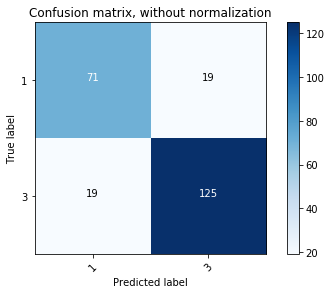

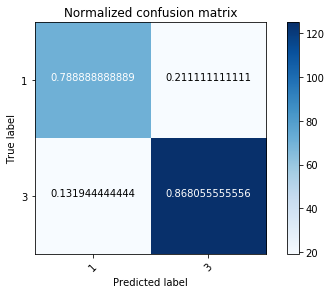

In [36]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix


# Split the data into a training set and a test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
#classifier = svm.SVC(kernel='linear', C=0.01)
#y_pred = classifier.fit(X_train, y_train).predict(X_test)

class_names = np.array([1,3])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()